---
<h1 style="text-align: center;">
Classification of Sonar Signals Using Neural Networks with PyTorch and TensorFlow
</h1>

<h1 style="text-align: center;">
Task 5
</h1>

<h3 style="text-align: center;">
Nov-26-2024
</h3>

---

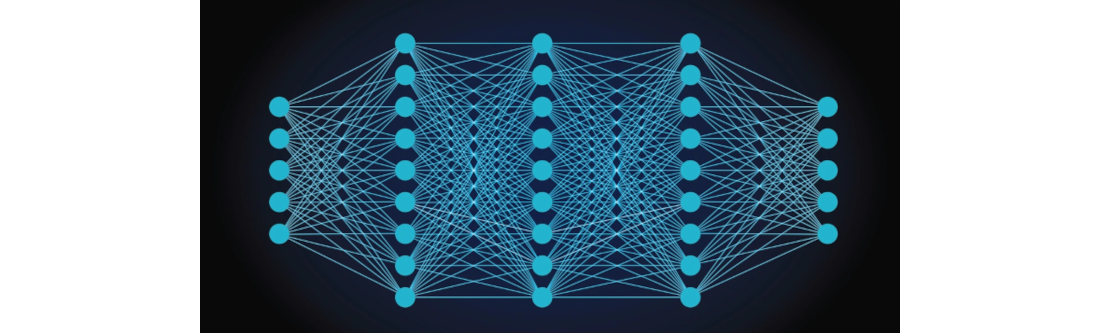

Image from https://aibusiness.com/ml/how-neural-networks-can-think-like-humans-and-why-it-matters#close-modal

### In this assignemnt, your task is to experiment with fully-connected, feed-forward neural networks to predict whether a sonar signal bounces off a metal cylinder or a cylindrical rock. The only data you have available is the sonar data in the dataset `sonar_dataset.csv`. Each row is a sample and columns are the sonar features, and the last column is the label of metal ("M") or rock ("R").

### You do not need to clean or preprocess the data in this assignment except encoding the label using the `LabelEncoder`; focus on building and training neural networks. You still need to determine what kind of neural network to use, which and how to tune any hyperparameters, how to measure performance, which models to select, and which final model to use. Try a few different architectures (e.g., number of layers, number of units in each layer), activation functions, and gradient descent algorithms (e.g., stochastic gradient descent, Adagrad, RMSprop, Adam). Tune hyperparameters (not necessarily with cross validation but definitely only using the training dataset) and measure the performance of the final model on a held-out test set. Additionally, track the performance of your experiments using Tensorboard, for example, track the average loss and accuracy per epoch on the training and test sets.

### Also submit a short report of your work describing all steps you took, explanations of why you took those steps, results, what you learned, how you might use what you learned in the future, and your conclusions.

---

### Write your code here

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    if torch.backends.mps.is_available()
    else "mps"
)
print(f"Using {device} device")

Using mps device


In [3]:
df = pd.read_csv('data/sonar_dataset.csv', header = None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values  # Label

# Label Encoding the Label Column here
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
num_samples, num_features = X.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 208
Number of features: 60


In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

from sklearn.model_selection import train_test_split

# New Training and Validation Sets 
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Converting to tensors
X_train_new_tensor = torch.tensor(X_train_new, dtype=torch.float32)
y_train_new_tensor = torch.tensor(y_train_new)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)

# Creating TensorDatasets
train_dataset = TensorDataset(X_train_new_tensor, y_train_new_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

input_size = X.shape[1]  # Number of features
num_classes = len(np.unique(y))  # Number of unique target classes

In [7]:
# Model 1: Simple Neural Network with ReLU and Adam Optimizer

class Model1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  
        self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 16) 
        self.fc4 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)  
        return out

model1 = Model1(input_size, num_classes)

In [8]:
# Model 2: A More Complex Neural Network with ReLU and SGD Optimizer

class Model2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

model2 = Model2(input_size, num_classes)

In [9]:
# Model 3: Neural Network with Tanh, and RMSprop Optimizer

class Model3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.tanh2 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

model3 = Model3(input_size, num_classes)

In [10]:
# Model 4: Neural Network with Tanh Activation and Adagrad Optimizer
class Model4(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model4, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(128, 64)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.tanh1(self.fc1(x))
        out = self.tanh2(self.fc2(out))
        out = self.fc3(out)  
        return out

model4 = Model4(input_size, num_classes)

In [11]:
# Model 5: Neural Network with Sigmoid Activation and RMSProp Optimizer
class Model5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model5, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(256, 128)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(128, 64)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.sigmoid1(self.fc1(x))
        out = self.sigmoid2(self.fc2(out))
        out = self.sigmoid3(self.fc3(out))
        out = self.fc4(out)  
        return out

model5 = Model5(input_size, num_classes)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, writer, num_epochs=200):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        # Training 
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation 
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Log to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', epoch_val_acc, epoch)

        # Printing every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    writer.flush()
    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
# Hyperparameters to test
batch_sizes = [16, 32, 64]
learning_rates = [0.1, 0.01, 0.001]

model_results = {}

def train_and_evaluate_model(model_class, optimizer_class, model_name):
    writer = SummaryWriter(log_dir=f'runs/{model_name}')
    
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_hyperparams = None
    best_model_state = None
    best_train_losses = None
    best_val_losses = None
    best_train_accs = None
    best_val_accs = None
    test_accuracy = None

    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"\nTraining {model_name} with batch size {batch_size} and learning rate {lr}:")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Train for the optimizer instance in code
            model = model_class(input_size, num_classes)
            if optimizer_class == optim.SGD:
                optimizer = optimizer_class(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
            elif optimizer_class == optim.Adagrad:
                optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
            elif optimizer_class == optim.RMSprop:
                optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)
            else:
                optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)

            train_losses, val_losses, train_accs, val_accs = train_model(
                model, train_loader, val_loader, criterion, optimizer, writer, num_epochs=100)
            
            # Finding the max vallidation accuracy for a combination
            max_val_acc = max(val_accs)
            if max_val_acc > best_val_acc:
                best_val_acc = max_val_acc
                best_hyperparams = {'batch_size': batch_size, 'learning_rate': lr}
                best_model_state = model.state_dict()
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_train_accs = train_accs
                best_val_accs = val_accs

            print(f"Max Validation Accuracy: {max_val_acc:.2f}% with batch size {batch_size} and learning rate {lr}")

    model = model_class(input_size, num_classes)
    model.load_state_dict(best_model_state)

    test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"\nTest Accuracy of the best {model_name}: {test_accuracy:.2f}% with batch size {best_hyperparams['batch_size']} and learning rate {best_hyperparams['learning_rate']}")

    # Stores the results
    model_results[model_name] = {
        'best_train_losses': best_train_losses,
        'best_val_losses': best_val_losses,
        'best_train_accs': best_train_accs,
        'best_val_accs': best_val_accs,
        'test_accuracy': test_accuracy,
        'best_hyperparams': best_hyperparams,
        'model_state': model.state_dict(),
        'model': model
    }

    writer.close()


Training Model 1 with batch size 16 and learning rate 0.1:
Epoch [20/100], Train Loss: 0.6575, Train Acc: 75.00%, Val Loss: 0.7357, Val Acc: 70.59%
Epoch [40/100], Train Loss: 0.6965, Train Acc: 53.79%, Val Loss: 0.6917, Val Acc: 52.94%
Epoch [60/100], Train Loss: 0.6900, Train Acc: 53.79%, Val Loss: 0.6926, Val Acc: 52.94%
Epoch [80/100], Train Loss: 0.6915, Train Acc: 53.79%, Val Loss: 0.6985, Val Acc: 52.94%
Epoch [100/100], Train Loss: 0.6910, Train Acc: 53.79%, Val Loss: 0.6921, Val Acc: 52.94%
Max Validation Accuracy: 85.29% with batch size 16 and learning rate 0.1

Training Model 1 with batch size 16 and learning rate 0.01:
Epoch [20/100], Train Loss: 0.0007, Train Acc: 100.00%, Val Loss: 2.2122, Val Acc: 82.35%
Epoch [40/100], Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 2.3923, Val Acc: 82.35%
Epoch [60/100], Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 2.3745, Val Acc: 82.35%
Epoch [80/100], Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 2.2942, Val Acc: 82.35%


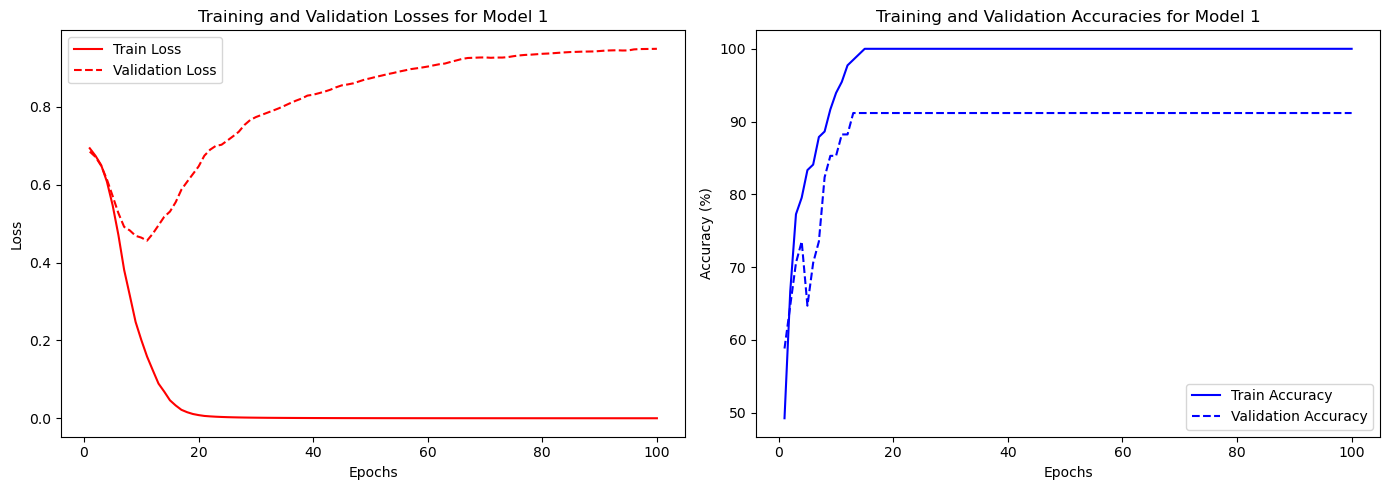

In [14]:
import matplotlib.pyplot as plt

# Train and Evaluate Model 1
train_and_evaluate_model(Model1, optim.Adam, 'Model 1')

# Plotting the training and validation losses and accuracies for Model 1
results = model_results['Model 1']  
epochs = range(1, len(results['best_train_losses']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['best_train_losses'], 'r-', label='Train Loss')
plt.plot(epochs, results['best_val_losses'], 'r--', label='Validation Loss')
plt.title('Training and Validation Losses for Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results['best_train_accs'], 'b-', label='Train Accuracy')
plt.plot(epochs, results['best_val_accs'], 'b--', label='Validation Accuracy')
plt.title('Training and Validation Accuracies for Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Training Model 2 with batch size 16 and learning rate 0.1:
Epoch [20/100], Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 1.9619, Val Acc: 82.35%
Epoch [40/100], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 1.9532, Val Acc: 82.35%
Epoch [60/100], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 1.9085, Val Acc: 82.35%
Epoch [80/100], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 1.8624, Val Acc: 82.35%
Epoch [100/100], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 1.8138, Val Acc: 82.35%
Max Validation Accuracy: 88.24% with batch size 16 and learning rate 0.1

Training Model 2 with batch size 16 and learning rate 0.01:
Epoch [20/100], Train Loss: 0.0060, Train Acc: 100.00%, Val Loss: 0.7005, Val Acc: 85.29%
Epoch [40/100], Train Loss: 0.0013, Train Acc: 100.00%, Val Loss: 0.7950, Val Acc: 85.29%
Epoch [60/100], Train Loss: 0.0007, Train Acc: 100.00%, Val Loss: 0.8538, Val Acc: 85.29%
Epoch [80/100], Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.8899, Val Acc: 85

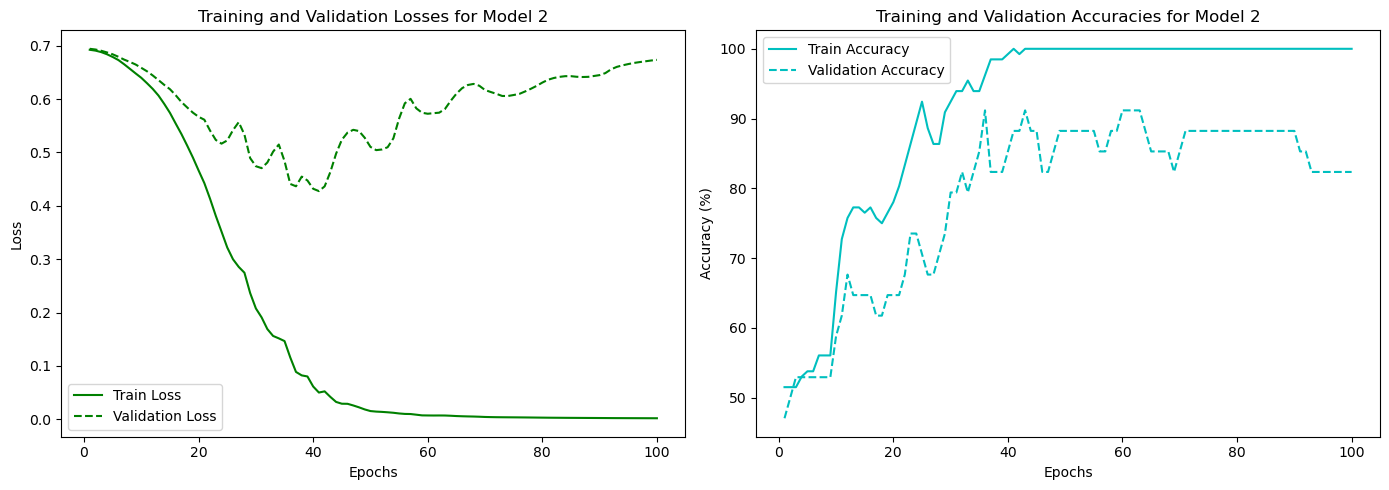

In [15]:
# Train and Evaluate Model 2
train_and_evaluate_model(Model2, optim.SGD, 'Model 2')

# Plotting the training and validation losses and accuracies for Model 2
results = model_results['Model 2']  
epochs = range(1, len(results['best_train_losses']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['best_train_losses'], 'g-', label='Train Loss')
plt.plot(epochs, results['best_val_losses'], 'g--', label='Validation Loss')
plt.title('Training and Validation Losses for Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results['best_train_accs'], 'c-', label='Train Accuracy')
plt.plot(epochs, results['best_val_accs'], 'c--', label='Validation Accuracy')
plt.title('Training and Validation Accuracies for Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Training Model 3 with batch size 16 and learning rate 0.1:
Epoch [20/100], Train Loss: 2.2762, Train Acc: 73.48%, Val Loss: 2.5062, Val Acc: 67.65%
Epoch [40/100], Train Loss: 0.6850, Train Acc: 83.33%, Val Loss: 2.0599, Val Acc: 67.65%
Epoch [60/100], Train Loss: 1.3750, Train Acc: 78.79%, Val Loss: 1.7025, Val Acc: 73.53%
Epoch [80/100], Train Loss: 1.4455, Train Acc: 75.76%, Val Loss: 1.3087, Val Acc: 70.59%
Epoch [100/100], Train Loss: 1.2948, Train Acc: 79.55%, Val Loss: 4.5329, Val Acc: 58.82%
Max Validation Accuracy: 82.35% with batch size 16 and learning rate 0.1

Training Model 3 with batch size 16 and learning rate 0.01:
Epoch [20/100], Train Loss: 0.0230, Train Acc: 100.00%, Val Loss: 0.6153, Val Acc: 85.29%
Epoch [40/100], Train Loss: 0.0183, Train Acc: 99.24%, Val Loss: 0.6010, Val Acc: 85.29%
Epoch [60/100], Train Loss: 0.0035, Train Acc: 100.00%, Val Loss: 0.9346, Val Acc: 79.41%
Epoch [80/100], Train Loss: 0.0007, Train Acc: 100.00%, Val Loss: 1.4285, Val Acc: 79.41%
E

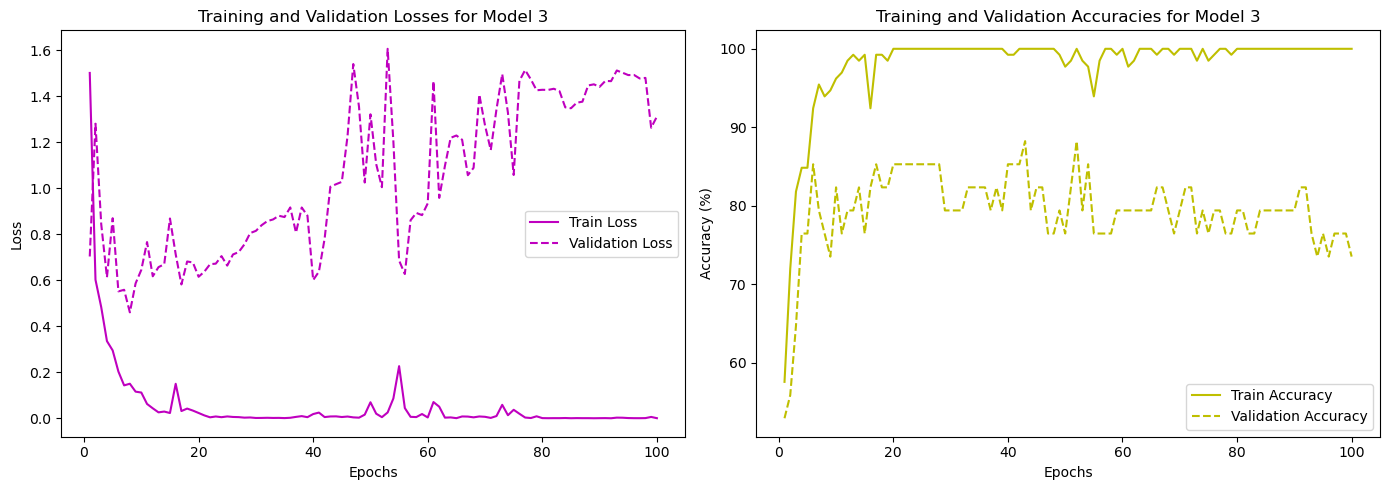

In [16]:
# Train and Evaluate Model 3
train_and_evaluate_model(Model3, optim.RMSprop, 'Model 3')

# Plotting the training and validation losses and accuracies for Model 3
results = model_results['Model 3'] 
epochs = range(1, len(results['best_train_losses']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['best_train_losses'], 'm-', label='Train Loss')
plt.plot(epochs, results['best_val_losses'], 'm--', label='Validation Loss')
plt.title('Training and Validation Losses for Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results['best_train_accs'], 'y-', label='Train Accuracy')
plt.plot(epochs, results['best_val_accs'], 'y--', label='Validation Accuracy')
plt.title('Training and Validation Accuracies for Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Training Model 4 with batch size 16 and learning rate 0.1:
Epoch [20/100], Train Loss: 0.0053, Train Acc: 100.00%, Val Loss: 0.8233, Val Acc: 79.41%
Epoch [40/100], Train Loss: 0.0011, Train Acc: 100.00%, Val Loss: 0.9474, Val Acc: 79.41%
Epoch [60/100], Train Loss: 0.0006, Train Acc: 100.00%, Val Loss: 0.9809, Val Acc: 79.41%
Epoch [80/100], Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 1.0083, Val Acc: 79.41%
Epoch [100/100], Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 1.0227, Val Acc: 79.41%
Max Validation Accuracy: 85.29% with batch size 16 and learning rate 0.1

Training Model 4 with batch size 16 and learning rate 0.01:
Epoch [20/100], Train Loss: 0.0459, Train Acc: 100.00%, Val Loss: 0.5955, Val Acc: 76.47%
Epoch [40/100], Train Loss: 0.0080, Train Acc: 100.00%, Val Loss: 0.7901, Val Acc: 79.41%
Epoch [60/100], Train Loss: 0.0037, Train Acc: 100.00%, Val Loss: 0.8475, Val Acc: 79.41%
Epoch [80/100], Train Loss: 0.0023, Train Acc: 100.00%, Val Loss: 0.9099, Val Acc: 79

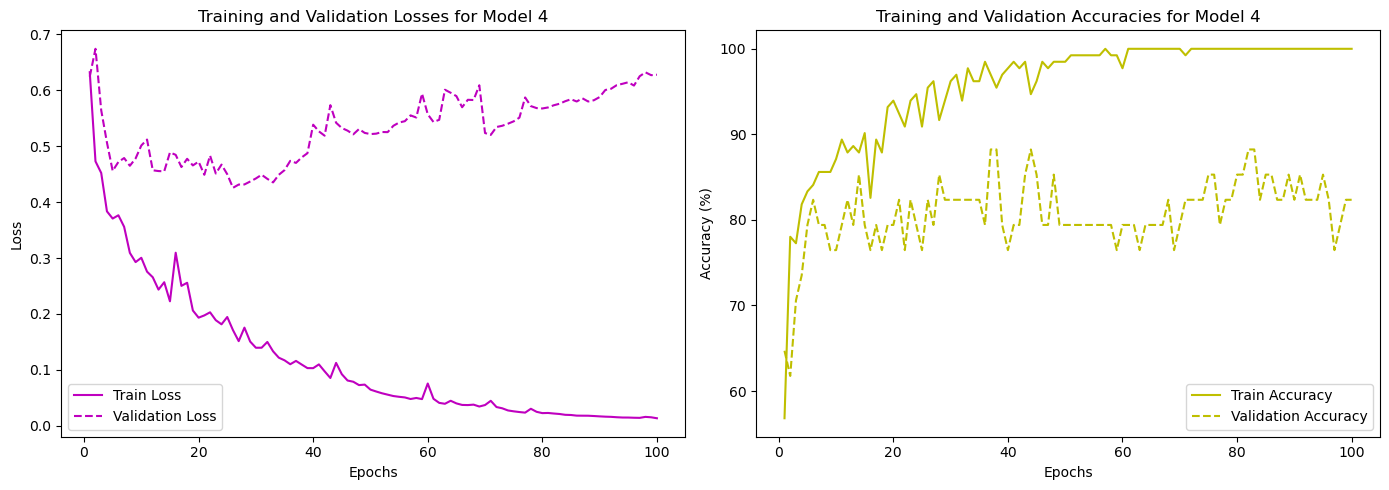

In [17]:
# Train and Evaluate Model 4
train_and_evaluate_model(Model4, optim.Adagrad, 'Model 4')

# Plotting the training and validation losses and accuracies for Model 4
results = model_results['Model 4'] 
epochs = range(1, len(results['best_train_losses']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['best_train_losses'], 'm-', label='Train Loss')
plt.plot(epochs, results['best_val_losses'], 'm--', label='Validation Loss')
plt.title('Training and Validation Losses for Model 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results['best_train_accs'], 'y-', label='Train Accuracy')
plt.plot(epochs, results['best_val_accs'], 'y--', label='Validation Accuracy')
plt.title('Training and Validation Accuracies for Model 4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Training Model 5 with batch size 16 and learning rate 0.1:
Epoch [20/100], Train Loss: 1.0460, Train Acc: 50.76%, Val Loss: 0.7779, Val Acc: 52.94%
Epoch [40/100], Train Loss: 0.7733, Train Acc: 52.27%, Val Loss: 0.7063, Val Acc: 52.94%
Epoch [60/100], Train Loss: 0.7703, Train Acc: 62.88%, Val Loss: 1.4189, Val Acc: 47.06%
Epoch [80/100], Train Loss: 1.6857, Train Acc: 55.30%, Val Loss: 0.7126, Val Acc: 52.94%
Epoch [100/100], Train Loss: 1.0774, Train Acc: 44.70%, Val Loss: 0.9502, Val Acc: 47.06%
Max Validation Accuracy: 52.94% with batch size 16 and learning rate 0.1

Training Model 5 with batch size 16 and learning rate 0.01:
Epoch [20/100], Train Loss: 0.4176, Train Acc: 81.06%, Val Loss: 0.5514, Val Acc: 79.41%
Epoch [40/100], Train Loss: 0.1713, Train Acc: 93.18%, Val Loss: 0.7172, Val Acc: 76.47%
Epoch [60/100], Train Loss: 0.1299, Train Acc: 93.94%, Val Loss: 0.7361, Val Acc: 79.41%
Epoch [80/100], Train Loss: 0.2570, Train Acc: 89.39%, Val Loss: 0.5158, Val Acc: 79.41%
Epoc

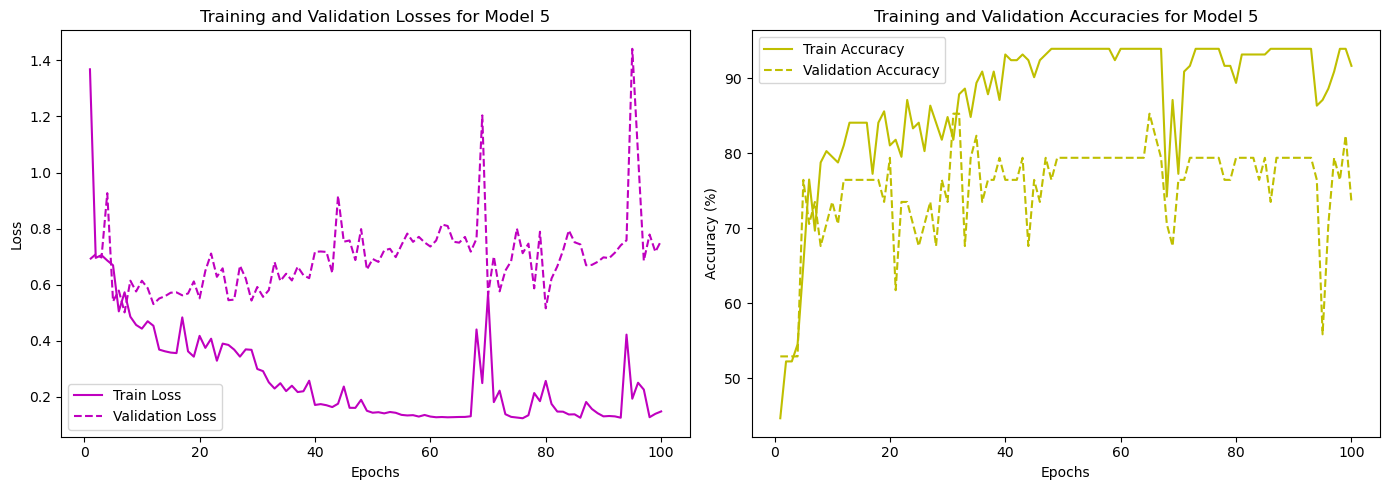

In [18]:
# Train and Evaluate Model 5
train_and_evaluate_model(Model5, optim.RMSprop, 'Model 5')

# Plotting the training and validation losses and accuracies for Model 5
results = model_results['Model 5'] 
epochs = range(1, len(results['best_train_losses']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['best_train_losses'], 'm-', label='Train Loss')
plt.plot(epochs, results['best_val_losses'], 'm--', label='Validation Loss')
plt.title('Training and Validation Losses for Model 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results['best_train_accs'], 'y-', label='Train Accuracy')
plt.plot(epochs, results['best_val_accs'], 'y--', label='Validation Accuracy')
plt.title('Training and Validation Accuracies for Model 5')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Printing the Final Results
print("\nFinal Results:")
for model_name, results in model_results.items():
    print(f"{model_name}: Train Loss = {results['best_train_losses'][-1]:.4f}, Train Accuracy = {results['best_train_accs'][-1]:.2f}%, "
          f"Val Loss = {results['best_val_losses'][-1]:.4f}, Val Accuracy = {results['best_val_accs'][-1]:.2f}%, "
          f"Test Accuracy = {results['test_accuracy']:.2f}%")


Final Results:
Model 1: Train Loss = 0.0001, Train Accuracy = 100.00%, Val Loss = 0.9487, Val Accuracy = 91.18%, Test Accuracy = 85.71%
Model 2: Train Loss = 0.0019, Train Accuracy = 100.00%, Val Loss = 0.6734, Val Accuracy = 82.35%, Test Accuracy = 80.95%
Model 3: Train Loss = 0.0004, Train Accuracy = 100.00%, Val Loss = 1.3120, Val Accuracy = 73.53%, Test Accuracy = 78.57%
Model 4: Train Loss = 0.0135, Train Accuracy = 100.00%, Val Loss = 0.6279, Val Accuracy = 82.35%, Test Accuracy = 83.33%
Model 5: Train Loss = 0.1482, Train Accuracy = 91.67%, Val Loss = 0.7569, Val Accuracy = 73.53%, Test Accuracy = 85.71%


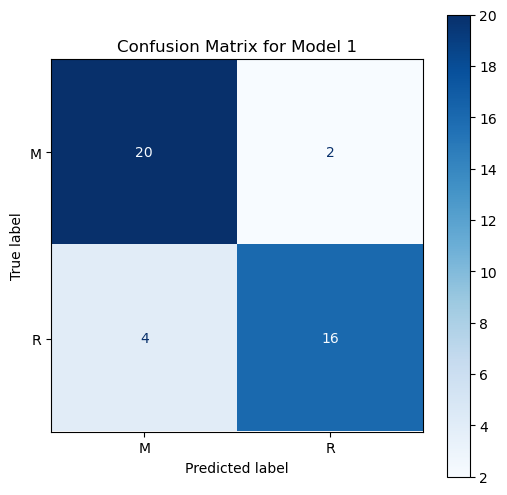

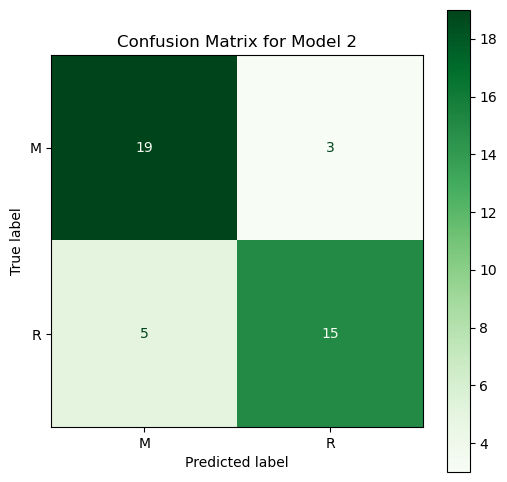

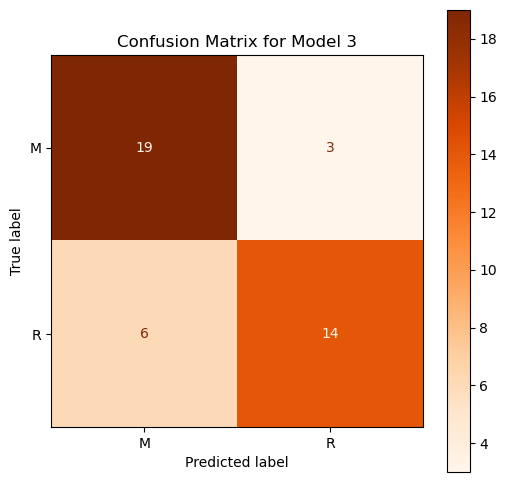

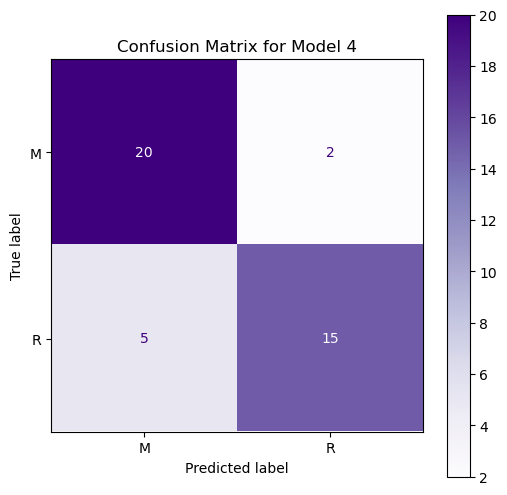

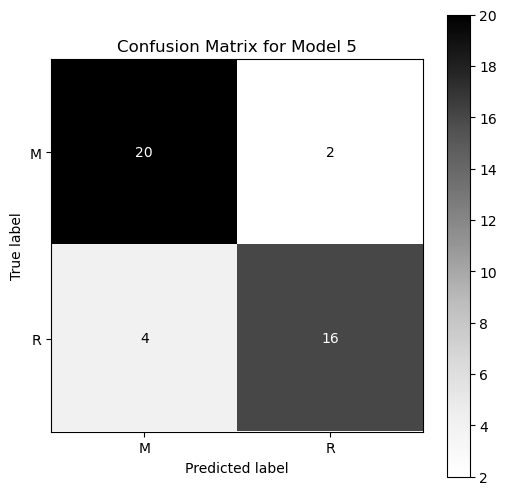

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model_name, results in model_results.items():
    model = results['model']
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)

    # Plotting the Confusion Matrix
    cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(6, 6))
    if model_name == 'Model 1':
        cmap = 'Blues'
    elif model_name == 'Model 2':
        cmap = 'Greens'
    elif model_name == 'Model 3':
        cmap = 'Oranges'
    elif model_name == 'Model 4':
        cmap = 'Purples'
    elif model_name == 'Model 5':
        cmap = 'Greys'
    else:
        cmap = 'Reds'
    disp.plot(ax=ax, cmap=cmap)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [21]:
# Finding the Best Model with Weighted Averages
train_weight = 0.2
val_weight = 0.3
test_weight = 0.5

weighted_scores = []
model_names = []
for model_name, results in model_results.items():
    train_acc = results['best_train_accs'][-1]
    val_acc = results['best_val_accs'][-1]
    test_acc = results['test_accuracy']
    weighted_score = (train_acc * train_weight) + (val_acc * val_weight) + (test_acc * test_weight)
    weighted_scores.append(weighted_score)
    model_names.append(model_name)

best_index = np.argmax(weighted_scores)
best_model_name = model_names[best_index]
best_score = weighted_scores[best_index]

print(f"\nThe best model is {best_model_name} with a weighted score of {best_score:.2f}%")


The best model is Model 1 with a weighted score of 90.21%


In [22]:
# Load the tensorboard extension
%load_ext tensorboard

# Using the tensorboard extension
%tensorboard --logdir=runs

---

### Write your report here

# Homework 5 - Sonar Dataset Report


## Data Initialization

### Dataset Loading
- Used `Cuda in PyTorch` to run the code on gpu instead of the cpu for faster response when dealing with neural networks.
- Loaded the sonar dataset using `pandas` and displayed the initial 5 rows of dataset using `df.head()`.

### Feature and Label Seperation
- Extracted `Features(X)` and `Labels(y)` respectively.


## Label Encoding Dataset
- Converted the `("M" for metal, "R" for rock)` string labels in the dataset to numerical values.
- Neural networks require numerical values for classification tasks.
- Also, further standardized the data to make it balanced.

### Dataset Summary
- Printed the features and labels in the dataset as `208 samples` and `60 features`.


## Dataset Spliting and Conversion to Tensor
- Split the dataset into training and test sets with an 80-20 split using `train_test_split`.
- This distribution ensures that the dataset is consistently split between training and testing sets.
- Further split the original train dataset into `new train tensor` and `val tensor` as 80-20.
- Converted new train, test, and val sets to `PyTorch tensors` to enable compatibility with the model.


## Building the Neural Network Models

- Start with `60 neurons` for the input layer as the `input_size`.

## Model 1: A Simple Neural Network with ReLU and Adam Optimizer
- Initialized a simple architecture with ReLU activation and several layers after the input layer.
- The first layer uses ReLU activation and has `64 neurons`.
- The second layer uses ReLU activation and has `32 neurons`.
- The third layer uses ReLU activation and has `16 neurons`.
- The output layer has `2 neurons` as bianry classfication. 

## Model 2: A More Complex Neural Network with ReLU and SGD Optimizer
- Initialized a more complex architecture with ReLU activation and several layers after the input layer.
- The first layer uses ReLU activation and has `256 neurons`.
- Used more neurons here to spread out the dataset to avoid any overfitting that might occur.
- The second layer uses ReLU activation and has `128 neurons`.
- The third layer uses ReLU activation and has `64 neurons`.
- The output layer has `2 neurons` as bianry classfication.

## Model 3: A Neural Network with Tanh and RMSprop Optimizer
- Initialized a neural network with Tanh activation and Dropout layers to tackle the overfitting issue.
- The first layer uses Tanh activation with `0.3 dropout rate` for the dropout layer, and has `128 neurons`.
- The second layer uses Tanh activation with `0.2 dropout rate` for the dropout layer, and has `64 neurons`.
- The output layer has `2 neurons` as bianry classfication.

## Model 4: Neural Network with Tanh Activation and Adagrad Optimizer
- Initialized a moderately deep neural network with Tanh activation to capture the non-linear relationships.
- The first layer uses Tanh activation and has `128 neurons`.
- The second layer uses Tanh activation and has `64 neurons`.
- The output layer has `2 neurons` for binary classification.

## Model 5: Neural Network with Sigmoid Activation and RMSProp Optimizer
- Initialized a deeper model using Sigmoid activation and to normalize the output between 0 and 1.
- The first layer uses Sigmoid activation and has `256 neurons`.
- The second layer uses Sigmoid activation and has `128 neurons`.
- The third layer uses Sigmoid activation and has `64 neurons`.
- The output layer has `2 neurons` for binary classification.


## Training and Hyperparameter Tuning 
### train_model
- Applied a training function `train_model` that includes both the training and validation phases.
- During the training phase,
    - Model is trainined using `train_loader` and loss is computed with `CrossEntropyLoss`.
    - Gradients and other parameters are computed using the optimizer `(Adam, SGD, or RMSprop)`.
- During the validation phase,
    - Model is evaluated using `val_loader`.
    - No gradient is computed with `torch.no_grad()` for regulation.
    - Validation loss and accuracy are calculated for hyperparameter tuning in the later step.
- Also, information is logged for tensorboard for the metrics below:
    - Training Loss (Loss/Train),
    - Validation Loss (Loss/Validation),
    - Training Accuracy (Accuracy/Train),
    - Validation Accuracy (Accuracy/Validation)
- Later the epoch is printed every 20 epoch to show a significant change.

### train_and_evaluate_model
- Tried three different batch sizes `[16, 32, 64]` and three different learning rates `[0.1, 0.01, 0.001]`.
- For each of the combinations here:
    - A new `DataLoader` is created for the training and validation datasets.
    - The model is trained and the max validation accuracy at a certain time of epoch is tracked.
    - For the best validation accuracy:
        - The best hyperparameters are tracked.
        - The state of the model (weights) is tracked.
        - The training and validation metrics are tracked.


## Apply the Optimizer and Plot Graph and Confusion Matrix
- Applied the `Adam` optimizer and plotted the metrics with matplotlib for Model 1
- Applied the `SGD` optimizer and plotted the metrics with matplotlib for Model 2
- Applied the `RMSProp` optimizer and plotted the metrics with matplotlib for Model 3
- Applied the `Adagrad` optimizer and plotted the metrics with matplotlib for Model 4
- Applied the `RMSProp` optimizer and plotted the metrics with matplotlib for Model 5
- Printed the confusion matrices for each model to visualize the tensors.

## Results
- The final results for the model were interesting and they were as following:
- In Model 1, `Train Accuracy = 100.00%, Val Accuracy = 91.18%, Test Accuracy = 85.71%`
- In Model 2,`Train Accuracy = 100.00%, Val Accuracy = 82.35%, Test Accuracy = 80.95%`
- In Model 3, `Train Accuracy = 100.00%, Val Accuracy = 73.53%, Test Accuracy = 78.57%`
- In Model 4, `Train Accuracy = 100.00%, Val Accuracy = 82.35%, Test Accuracy = 83.33%`
- In Model 5, `Train Accuracy = 91.67%, Val Accuracy = 73.53%, Test Accuracy = 85.71%`

## Finalizing the best model and Tensorboard Tracking
- Finally, used a weighted average of `0.2 for train`, `0.3 for validation `and `0.5 for test to predict` the best model on average.
- Used Tensorboard at the bottom code to track the performance of the experiments as advised.
- Model 1 worked the best with an average weighted score of `90.21%`.


## What I have learned?
- Throughout this assignment, I learned the importance of balancing model complexity with the dataset size to prevent overfitting. I learned about how simpler models can perform better with limited data, as there are less chances of overfitting and complex models can do well on the training data but fail to generalize overall. Using different batch sizes, and learning rates also helped to significantly improve model performance and give a clear choice for a combination of them. I also learned how validation sets play an important role in hyperparamter tuning without bias in results. Then the use of different activation functions like `ReLU, Tanh, Sigmoid` and different optimizers like `Adam, SGD, RMSProp, Adagrad` helped me understand how certain function or optimizers work better with each other. Another interesting thing I found was that, dropout layers can help with generalization and the weight decay method used in my code like `weight_decay=1e-4` can help to prevent overfitting. Overall, the working of neural networks was a very interesting concept that increased my curiosity into the filed even more.


## How I Might Use What I Learned in the Future?
- I plan to apply my understanding from this homework at my work, school, and on personal proejcts. Concepts about simpler models being able to generalize better and importance of choosing model complexity for model selection can help me choose the right model. The hyperparameter tuning techniques can also help me in future work or projects that involve machine learning or similar concepts. Techniques like regularization with weight decay and dropout can be used for improving a model's generalization. Using visualization techniques like tensorboard also helped me to better visualize with I think would be one of the most useful learning of these as that is a industry level visualization tool. 


## Conclusion
- In this project, I was able to create a neural network model to classify sonar signals. By experimenting with different neural architectures, activation functions, optimizers, and hyperparameters, I was able to find that a simpler architecture like the one in model 1 worked best for the limited data that was provided with the datatset. As there was less dataset information, there was no need to scatter the neurons to around 256 and the model worked great with just 64 neurons and gave acceptable accurcacy and losses. Overall, I learned how simplicity in models can lead to better generalization, like with the limited data provided here. Using regulization techniques, and careful hyperparameter tuning were important to prevent overfitting in the model and ultimately improve the model performance. The different insights that I was able to get from this project including neural networks and machine leartning can be very useful for any future work that I do in the field. 

---